In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train = pd.read_csv(r"C:/Users/Dileemre/Desktop/jupyter/DATAAITEAM/train.csv", dtype = np.float32)

targets_np = train.label.values
features_np = train.loc[:,train.columns != "label"].values/255

features_train, features_test, targets_train, targets_test = train_test_split(features_np,
                                                                             targets_np,
                                                                             test_size = 0.2,
                                                                             random_state = 42)

x_train = torch.from_numpy(features_train)
y_train = torch.from_numpy(targets_train).type(torch.LongTensor)

x_test = torch.from_numpy(features_test)
y_test = torch.from_numpy(targets_test).type(torch.LongTensor)

batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

train = torch.utils.data.TensorDataset(x_train, y_train)
test = torch.utils.data.TensorDataset(x_test, y_test)

train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

In [3]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True) # batch_first=True (batch_dim, seq_dim, feature_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [4]:
input_dim = 28
hidden_dim = 100
layer_dim = 1
output_dim = 10
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
error = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [5]:
seq_dim = 28
loss_list = []
iter_list = []
acc_list = []
count = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        train = Variable(images.view(-1, seq_dim, input_dim)).requires_grad_()
        
        optimizer.zero_grad()
        outputs = model(train)
        loss = error(outputs, labels)
        loss.backward()
        optimizer.step()
        count += 1
        if count % 50 == 0:
            correct = 0
            total = 0
            for images, labels in test_loader:
                test = images.view(-1, seq_dim, input_dim)
                outputs = model(test)
                _, preticted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (preticted == labels).sum()

            acc = 100 * correct / total
            loss_list.append(loss.data)
            iter_list.append(count)
            acc_list.append(acc)
            
        if count % 500 == 0:
            print("iter {} loss {} acc {}".format(count, loss.data.item(), acc))

iter 500 loss 2.2517354488372803 acc 18.880952835083008
iter 1000 loss 1.2187765836715698 acc 61.5476188659668
iter 1500 loss 0.38039058446884155 acc 86.21428680419922
iter 2000 loss 0.34546372294425964 acc 92.13095092773438
iter 2500 loss 0.17843171954154968 acc 93.4047622680664
iter 3000 loss 0.1636975109577179 acc 95.05952453613281
iter 3500 loss 0.1654830425977707 acc 95.67857360839844
iter 4000 loss 0.023857684805989265 acc 95.80952453613281
iter 4500 loss 0.09833070635795593 acc 96.0
iter 5000 loss 0.05535149574279785 acc 96.58333587646484
iter 5500 loss 0.10211256891489029 acc 96.58333587646484


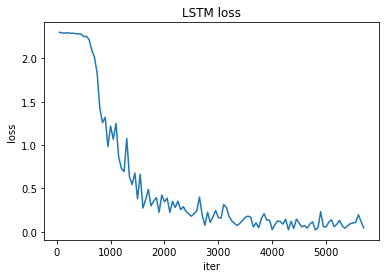

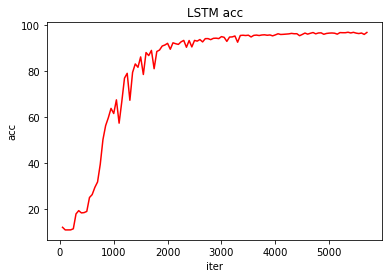

In [8]:
plt.plot(iter_list, loss_list)
plt.xlabel("iter")
plt.ylabel("loss")
plt.title("LSTM loss")
plt.show()

plt.plot(iter_list, acc_list, color = "red")
plt.xlabel("iter")
plt.ylabel("acc")
plt.title("LSTM acc")
plt.show()